In [2]:
%load_ext autoreload
%autoreload 2
%env CUDA_VISIBLE_DEVICES=1
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib

from sklearn.decomposition import PCA

import seaborn as sns
import ncvis
import os
import numpy as np
import sys
sys.path.append("..")
from vis_utils.loaders import load_mnist
from vis_utils.plot import add_scale
from vis_utils.utils import  save_dict, load_dict, kNN_graph, find_ab_params, compute_low_dim_sims
from vis_utils.tsne_wrapper import TSNEwrapper

from openTSNE.affinity import Affinities
import umap
import sklearn.datasets
import pickle

import scipy.sparse

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: CUDA_VISIBLE_DEVICES=1


In [3]:
root_path = "/export/ial-nfs/user/sdamrich/nce_data"
fig_path = "/export/ial-nfs/user/sdamrich/nce_data/figures"

In [4]:
# parameters for all methods
a = 1.0
b = 1.0
seed = 0
n_noise = 5
alpha_Q = 0.001
alpha = 1.0
n_epochs = 750


k = 15
cmap = matplotlib.cm.get_cmap("tab10")

In [5]:
# get data
x, y = load_mnist(root_path)
print(x.shape)

try:
    x50 = np.load(os.path.join(root_path, "mnist", "mnist_pca50.npy"))
except FileNotFoundError:
    pca50d = PCA(n_components=50, random_state=0)
    x50 = pca50d.fit_transform(x)
    np.save(os.path.join(root_path, "mnist", "mnist_pca50.npy"), x50)

try:
    x2 = np.load(os.path.join(root_path, "mnist", "mnist_pca2.npy"))
except FileNotFoundError:
    pca2d = PCA(n_components=2, random_state=0)
    x2 = pca2d.fit_transform(x)
    np.save(os.path.join(root_path, "mnist", "mnist_pca2.npy"), x2)



(70000, 784)


In [6]:
file_name = os.path.join(root_path,
                         "mnist",
                         f"sknn_graph_k_{k}_metric_euclidean.npz")
try:
    sknn_graph = scipy.sparse.load_npz(file_name)
except IOError:
    knn_graph = kNN_graph(x50.astype("float"),
                          k,
                          metric="euclidean").cpu().numpy().flatten()
    knn_graph = scipy.sparse.coo_matrix((np.ones(len(x)*k),
                                         (np.repeat(np.arange(x.shape[0]), k),
                                          knn_graph)),
                                        shape=(len(x), len(x)))
    sknn_graph = knn_graph.maximum(knn_graph.transpose()).tocoo()

    scipy.sparse.save_npz(file_name, sknn_graph)

affinities = np.stack([sknn_graph.row, sknn_graph.col], axis=1)

In [15]:
noise_in_ratios = np.array([n_noise/len(x) / (len(x)-1),
                            #1e-6, 2e-6, 5e-6,
                            #1e-5, 2e-5, 5e-5,
                            #1e-4, 2e-4, 5e-4,
                            1e-3, 2e-3, 5e-3,
                            1e-2, 2e-2, 5e-2,
                            1e-1, 2e-1, 5e-1,
                            1, 2, 5,
                            10, 20, 50
                            ])

In [16]:
ncvis_data_list = []
rescale = True
fix_Q = False
learn_Q = False
for noise_in_ratio in noise_in_ratios:
    file_name = os.path.join(root_path,
                             "mnist",
                             f"ncvis_bin_k_{k}_n_epochs_{n_epochs}_fix_Q_{fix_Q}_noise_in_ratio_{noise_in_ratio}_learn_Q_{learn_Q}_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_a_{a}_b_{b}_init_pca_rescale_{rescale}.pkl")
    if rescale:
        pca_ncvis = x2 / (np.std(x2[:, 0]) * 10000)
    else:
        pca_ncvis = x2
    try:
        ncvis_data = load_dict(file_name)
    except FileNotFoundError:
        ncvisualizer = ncvis.NCVis(distance='correlation',
                                   n_epochs=n_epochs,
                                   random_seed=seed,
                                   fix_Q=fix_Q,
                                   noise_in_ratio=noise_in_ratio,
                                   learn_Q=learn_Q,
                                   n_noise=n_noise,
                                   alpha=alpha,
                                   alpha_Q=alpha_Q,
                                   a=a,
                                   b=b)

        embd = ncvisualizer.fit_transform(x50,
                                          affinities=affinities,
                                          init=pca_ncvis,
                                          log_embds=False,
                                          log_nce=False,
                                          log_nce_norm=False,
                                          log_nce_no_noise=False)
        save_dict(ncvisualizer.aux_data, file_name)
        ncvis_data = ncvisualizer.aux_data
    ncvis_data_list.append(ncvis_data)
    print(f"Done with {noise_in_ratio}")

Done with 1.020422740733031e-09
Done with 0.001
Done with 0.002
Done with 0.005
Done with 0.01
Done with 0.02
Done with 0.05
Done with 0.1
Done with 0.2
Done with 0.5
Done with 1.0
Done with 2.0
Done with 5.0
Done with 10.0
Done with 20.0
Done with 50.0


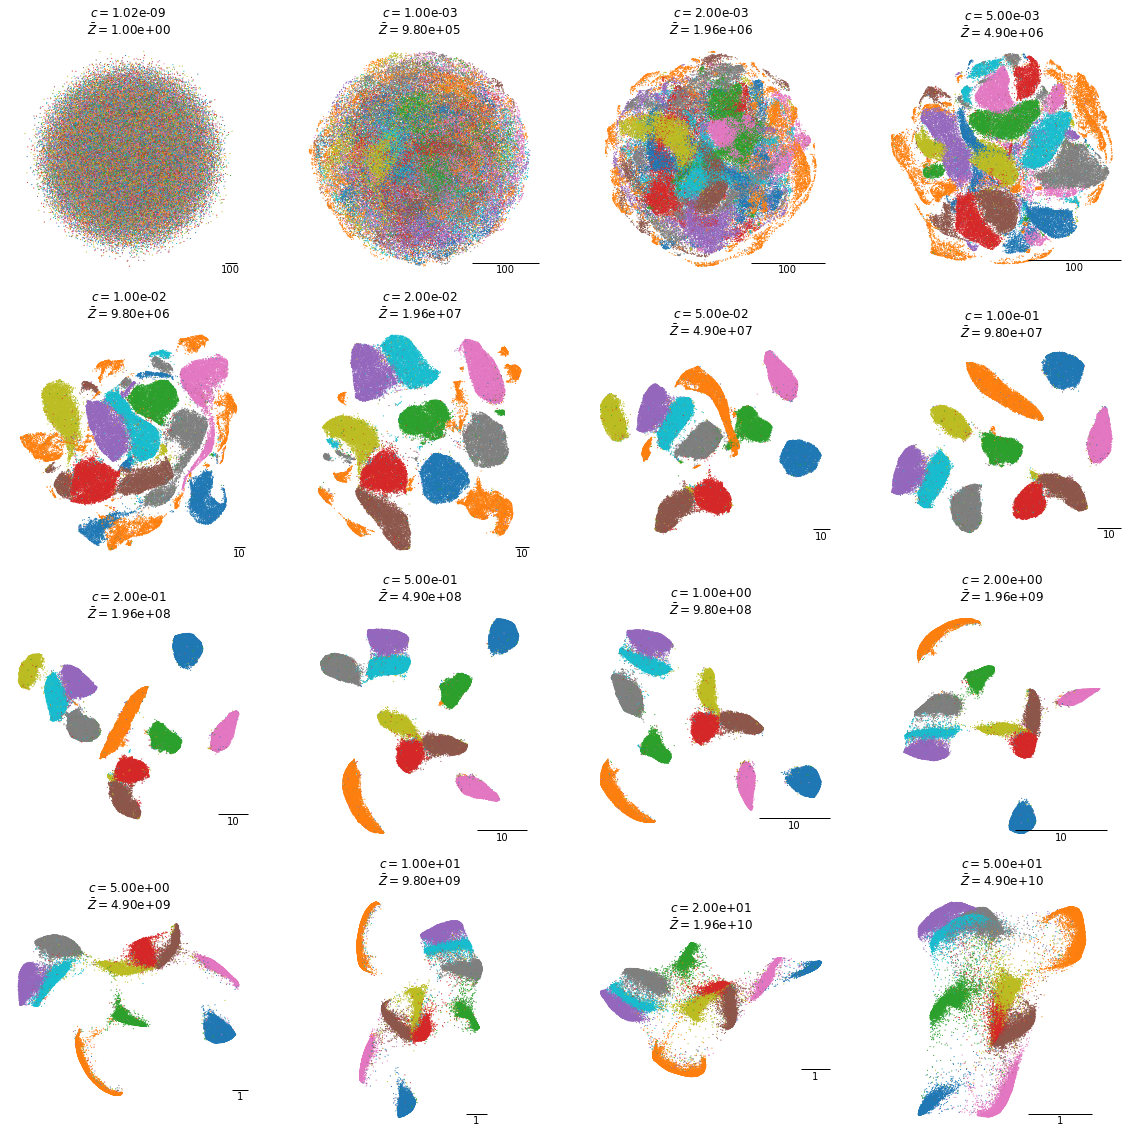

In [59]:
fig, ax = plt.subplots(4,4, figsize=(20,20))
n_exp = len(ncvis_data_list)
for i in range(n_exp):
    embd = ncvis_data_list[i]["embd"]
    cax = ax[int(i / 4), i % 4]
    cax.scatter(*embd.T, c=y, s=5, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

    cax.axis("off")
    cax.set_aspect("equal")
    cax.set_title(r"$c=${:.2e}".format(noise_in_ratios[i])
                  + "\n" +r"$\bar{Z}=$"+"{:.2e}".format(noise_in_ratios[i] / (n_noise / len(x) / (len(x)-1))))

    add_scale(cax, embd)

fig.savefig(os.path.join(fig_path,
                         f"ncvis_mnist_n_epochs_{n_epochs}_fix_Q_{fix_Q}_many_noise_in_ratio_seed_{seed}_n_noise_{n_noise}_alpha_{alpha}_alpha_Q_{alpha_Q}_learn_Q_{learn_Q}_rescale_{rescale}.png"),
            bbox_inches='tight',
            pad_inches=0,
            dpi=300,
            transparent=False,
            facecolor='white')

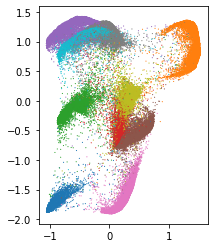

In [57]:
plt.scatter(*ncvis_data_list[-1]["embd"].T, c=y, s=5, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)
plt.gca().set_aspect("equal")


# t-SNE

In [13]:
n_early_epochs = 0
perplexity = 2*k
rescale_tsne = True

if rescale_tsne:
    pca_tsne = x2 / (np.std(x2[:, 0] * 10000))
else:
    pca_tsne = x2


affinities_tSNE = Affinities()
affinities_tSNE.P = (sknn_graph / sknn_graph.sum()).tocsr()

In [14]:
log_kl = True
log_embds = False
log_Z = True
file_name = os.path.join(root_path,
                         "mnist",
                         f"tsne_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.pkl")

In [15]:
try:
    tsne_data = load_dict(file_name)
except FileNotFoundError:
    tsne = TSNEwrapper(perplexity=perplexity,
                       metric="euclidean",
                       n_jobs=-1, # n_jobs=-10 does not work well, the cell does not print anything
                       random_state=seed,
                       verbose=True,
                       n_iter = n_epochs,
                       early_exaggeration_iter = n_early_epochs,
                       callbacks_every_iters=1,
                       log_kl=log_kl,
                       log_embds=log_embds,
                       log_Z=log_Z,
                       initialization=pca_tsne)
    embd = tsne.fit_transform(x, affinities=affinities_tSNE)

    # compute kl inv sq for tSNE

    tsne_kl_div_inv_sq = []

    save_dict(tsne.aux_data, file_name)
    tsne_data = tsne.aux_data

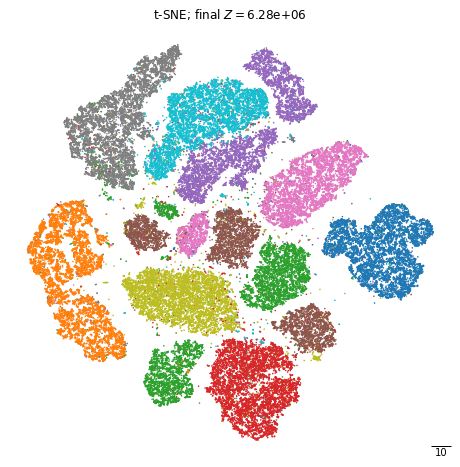

In [18]:
epoch = -1

plt.figure(figsize=(8,8))
plt.scatter(*tsne_data["embd"].T, c=y, s=10, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")
add_scale(plt.gca(), tsne_data["embd"])
plt.gca().set_title(r"t-SNE; final $Z=${:.2e}".format(tsne_data['Zs'][-1].cpu().numpy()[0]))
plt.savefig(os.path.join(fig_path,
                         f"tsne_mnist_bin_k_{k}_n_epochs_{n_epochs}_n_early_epochs_{n_early_epochs}_perplexity_{perplexity}_seed_{seed}_log_kl_{log_kl  }_log_embds_{log_embds}_init_pca_rescale_{rescale_tsne}.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300,
            transparent=False,
            facecolor='white')

## UMAP

In [7]:
lr = 1.0
rescale_umap = False

if rescale_umap:
    pca_umap = x2 / (np.std(x2[:, 0]) * 10000)
else:
    pca_umap = x2

In [8]:
filename = os.path.join(root_path, "mnist", f"umap_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}.pkl")
try:
    with open(filename, "rb") as file:
        umapper = pickle.load(file)
        embd_umap = umapper.embedding_
except FileNotFoundError:
    umapper = umap.UMAP(n_neighbors=k,
                        n_epochs=n_epochs,
                        log_losses="after",
                        a=a,
                        b=b,
                        log_embeddings=True,
                        log_norm=True,
                        log_kl=True,
                        random_state=seed,
                        verbose=True,
                        init=pca_umap,
                        graph=sknn_graph,
                        learning_rate=lr)
    embd = umapper.fit_transform(x)
    with open(filename, "wb") as file:
        pickle.dump(umapper, file, pickle.HIGHEST_PROTOCOL)

UMAP(a=1.0, b=1.0, dens_frac=0.0, dens_lambda=0.0,
     init=array([[ 122.24924 , -316.2177  ],
       [1010.4965  , -289.94275 ],
       [ -58.998962,  393.69196 ],
       ...,
       [-271.50937 ,  590.07587 ],
       [-310.22583 , -116.75282 ],
       [1058.8643  ,  -83.38373 ]], dtype=float32),
     log_embeddings=True, log_kl=True, log_losses='after', log_norm=True,
     n_epochs=750, random_state=0, verbose=True)
Construct fuzzy simplicial set
Fri Feb 18 12:55:36 2022 Construct embedding


/export/data/sdamrich/anaconda3/envs/nce/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


	completed  0  /  750 epochs
	completed  75  /  750 epochs
	completed  150  /  750 epochs
	completed  225  /  750 epochs
	completed  300  /  750 epochs
	completed  375  /  750 epochs
	completed  450  /  750 epochs
	completed  525  /  750 epochs
	completed  600  /  750 epochs
	completed  675  /  750 epochs
Fri Feb 18 13:44:13 2022 Finished embedding


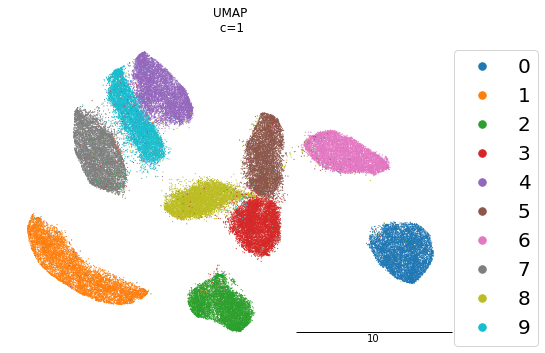

In [17]:
epoch=-1
plt.figure(figsize=(8,8))
plt.scatter(*umapper.aux_data["embeddings"][epoch].T, c=y, s=5, marker=".", cmap="tab10", edgecolor="none", alpha=1.0)

plt.axis("off")
plt.gca().set_aspect("equal")
add_scale(plt.gca(), umapper.aux_data["embeddings"][epoch])

plt.gca().set_title("UMAP\n c=1")


# dummy dots for legend
dots = []
for i in range(len(np.unique(y))):
    dot = mlines.Line2D([], [], color=cmap(i), marker='.', linestyle="none", markersize=15, label=np.unique(y)[i])
    dots.append(dot)

plt.legend(handles=dots, prop={'size': 20}, loc=(1,0))

plt.savefig(os.path.join(fig_path,
                         f"umap_mnist_bin_k_{k}_n_epochs_{n_epochs}_lr_{lr}_seed_{seed}_a_{a}_b_{b}_init_pca_rescaled_{rescale_umap}_legend.png"),
            bbox_inches = 'tight',
            pad_inches = 0,
            dpi=300,
            transparent=False,
            facecolor="white")